# Inaugural Project

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import inauguralproject

# Question 1

We solve the model by scipy-optimization.

First, we define the relevant variables. 

Second, we define our utility function and budget constraint as functions. The utility function returns the utility from the given inputs - this is what we want to optimize. The budget-constraint returns the budget given the values herein. 

Third, we define a decision-function, returning the utility, given our knowledge, that consumption equals the budget.

Fourth, we define our optimization-function. Here, we optimize the decision-function for labor, given all the other values. This returns the optimal labor, which enables us to calculate the consumption and utility of the consumer. 

In [2]:
#Defining variables:
m=1 #money
v=10 #disutility of labour supply
e=0.3 #frisch
tau_0=0.4 #ltax
tau_1=0.1 #ttax
kappa=0.4 #cutoff
w=0.5

In [3]:

# Defining tax as function of various tax parameters, labour, and wages
def tax(l,w,tau_0,tau_1, kappa):
    return tau_0*w*l+tau_1*np.fmax(w*l-kappa,0)

# Defining utility function and budget constraint:
def budget_constraint(l,m,w,tau_0,tau_1, kappa):
    # Returning total resources in terms of wage less taxes and cash 
    budget=m+w*l-w*l*tau_0-tau_1*max((w*l-kappa),0)
    return budget

def utility(c,l,v,e):
    # Returning utility from labour supply and consumption
    u=np.log(c)-v*l**(1+1/e)/(1+1/e)
    return u

In [4]:
# Defining a function, setting consumption equal to budget (as we know, the consumer chooses to spend entire budget due to the monotonously increasing utility function),
# Making this function return the utility, while c = m.
def decision(l,v,e,m,w,tau_0,tau_1,kappa):
    c=budget_constraint(l,m,w,tau_0,tau_1, kappa)
    return utility(c,l,v,e)

# Defining the optimizer-function, optimizing the consumer's decision function for l, given all other values in decision (defined above):
def optimizer(v,e,m,w,tau_0,tau_1,kappa):
    # Defining 
    obj = lambda l: -decision(l,v,e,m,w,tau_0,tau_1,kappa)
    sol = optimize.minimize_scalar(obj,bounds=(1e-8,1),method='bounded')
    return sol.x
 

In [5]:
# Draws out variables from the optimizer-list.
lstar=optimizer(v,e,m,w,tau_0,tau_1,kappa)
cstar=budget_constraint(lstar,m,w,tau_0,tau_1, kappa)
ustar=utility(cstar,lstar,v,e)
print('Given W = 0.5 we have:')
print(f'Labour supply: {lstar:.3f}')
print(f'Consumption: {cstar:.3f}')
print(f'Utility: {ustar:.3f}')

Given W = 0.5 we have:
Labour supply: 0.339
Consumption: 1.102
Utility: 0.076


# Question 2

In this problem we generate a sequence of 10000 random numbers from a uniform distribution to represent the individual wages of the 10000 people in the population. These numbers are saved to a list. We then create a for loop which appends the optimal amount of labour for each individual consumer given their wage and saves these to a list. From the optimal labour supply, we derive the optimal consumption level, which also is appended to a list.

<function matplotlib.pyplot.show(*args, **kw)>

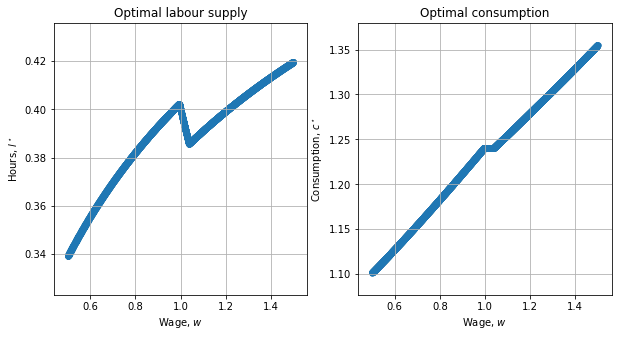

In [6]:
#Creating the wage list based on a uniform distribution
N=10000
np.random.seed(1986)
wi_vec=np.linspace(0.5,1.5,N)

#Adding empty lists to append to
l_vec=np.empty(N)
c_vec=np.empty(N)

for i in range(N):
    l_vec[i] = optimizer(v,e,m,wi_vec[i],tau_0,tau_1,kappa)
    c_vec[i] = budget_constraint(l_vec[i],m,wi_vec[i],tau_0,tau_1, kappa)


# Creating blank figure
fig = plt.figure(figsize=(10,5))

# Plot of optimal labour supply
l_vec_plot = fig.add_subplot(1,2,1)
l_vec_plot.scatter(wi_vec,l_vec,lw=0.1)

l_vec_plot.set_title("Optimal labour supply")
l_vec_plot.set_xlabel("Wage, $w$")
l_vec_plot.set_ylabel("Hours, $l^\star$")
l_vec_plot.grid(True)

# Plot of optimal consumption
c_vec_plot = fig.add_subplot(1,2,2)
c_vec_plot.scatter(wi_vec,c_vec,lw=0.1)

c_vec_plot.set_title("Optimal consumption")
c_vec_plot.set_xlabel("Wage, $w$")
c_vec_plot.set_ylabel("Consumption, $c^\star$")
c_vec_plot.grid(True)

# Printing plot
plt.show


In both functions, plotted, a kink can be seen when $w=1$. Moreover, consistent with theory consumption and labour depend positively on wage level. 

# Question 3

To calculate the total tax revenue we compute the tax for each consumer and sum them to get the total tax revenue.  

In [7]:
T = np.sum(tax(l_vec,wi_vec,tau_0,tau_1, kappa))
print(f'total tax revenue is: {T:.2f}')

total tax revenue is: 1630.19


# Question 4

This problem is entirely the same as the above, though now the Frish elasticity is lowered to 0.1 (before 0.3), thus the same level of labour has more utility to the individual now. We define a a function calculating the tax revenue based on the new vectors of optimal amount of labour supply and consumption.

In [8]:
e_low=0.1
#Defining cuntion:
def tax_revenue(v,e_low,m,wi_vec,tau_0,tau_1,kappa):
    
    # a. optimal labor supply
    l_vec = np.zeros(N)
    for i in range(N):
        l_vec[i] = optimizer(v,e_low,m,wi_vec[i],tau_0,tau_1,kappa)
        
    # b. taxes
    T = np.sum(tax(l_vec,wi_vec,tau_0,tau_1,kappa))    
    
    return T
tax_revenue(v,e_low,m,wi_vec,tau_0,tau_1,kappa)

3196.881000410794

The new tax-revenue is consistent with our expectations, since individuals are now willing to work more because their utility for working has increased. The higher level of labour supply results in a higher total tax-revenue from $\tau_1$.

# Question 5

Here, we find the tax rates and tax cutoff, such that we maximize tax revenue given the consumers behavior. 

In [13]:
#defining the objective function to minimise the negative value of the tax revenue
def obj1(x,v,e,m,wi_vec,tau_0,tau_1,kappa):
    
    #assigning tax parameters to list within the function so they are only defined locally
    tau_0=x[0]
    tau_1=x[1]
    kappa=x[2]
    #calculating tax revenue
    T = tax_revenue(v,e,m,wi_vec,tau_0,tau_1,kappa)
    return -T


In [14]:
#initialising with the calibration from question 1
guess = np.array([tau_0,tau_1,kappa])

#setting bounds of tax rates and kappa
bounds = ((0,1),(0,1),(0,1.5))

#using SLSQP to optimise for tau_0,tau_1, and kappa
result = optimize.minimize(obj1, guess, method='SLSQP',bounds=bounds, args=(v,e,m,wi_vec,tau_0,tau_1,kappa))


In [16]:
print(f'The optimal $tau_0$ is {result.x[0]:.4f}')
print(f'The optimal $tau_1$ is {result.x[1]:.4f}')
print(f'The optimal kappa is {result.x[2]:.4f}')
print(f'This yields the following tax revenue:{-result.fun:.4f}')

The optimal $tau_0$ is 0.7854
The optimal $tau_1$ is 0.0000
The optimal kappa is 0.0000
This yields the following tax revenue:2466.8603


# Conclusion

We solved the consumer problem, yielding the optimal labour and consumption maximizing utility of the agent. 
Next, we calculated the expected tax revenue given the consumer preferences. We can conclude that decreased Frish-elasticity results in a higher total tax-revenue.
